In [37]:
%%bash
set -euo pipefail

REPO="https://github.com/alexgkendall/SegNet-Tutorial.git"
DEST="/content/data/SegNet-Tutorial"
OUT="/content/data/CamVid"

mkdir -p /content/data
rm -rf "$DEST" "$OUT"

echo "Cloning repo (sparse: CamVid only)..."
git clone --depth 1 --filter=blob:none --sparse "$REPO" "$DEST" >/dev/null
cd "$DEST"
git sparse-checkout set CamVid >/dev/null

echo "Copying CamVid folder to $OUT..."
mkdir -p "$(dirname "$OUT")"
cp -r "$DEST/CamVid" "$OUT"

echo ""
echo "Top-level contents:"
ls -la "$OUT" | head -n 50

echo ""
echo "Use in notebook:"
echo "data_dir = \"$OUT\""


Cloning repo (sparse: CamVid only)...
Copying CamVid folder to /content/data/CamVid...

Top-level contents:
total 140
drwxr-xr-x 8 root root  4096 Jan 18 20:25 .
drwxr-xr-x 4 root root  4096 Jan 18 20:25 ..
drwxr-xr-x 2 root root 12288 Jan 18 20:25 test
drwxr-xr-x 2 root root 12288 Jan 18 20:25 testannot
-rw-r--r-- 1 root root 19215 Jan 18 20:25 test.txt
drwxr-xr-x 2 root root 20480 Jan 18 20:25 train
drwxr-xr-x 2 root root 20480 Jan 18 20:25 trainannot
-rw-r--r-- 1 root root 30053 Jan 18 20:25 train.txt
drwxr-xr-x 2 root root  4096 Jan 18 20:25 val
drwxr-xr-x 2 root root  4096 Jan 18 20:25 valannot
-rw-r--r-- 1 root root  7777 Jan 18 20:25 val.txt

✅ Use in notebook:
data_dir = "/content/data/CamVid"


Cloning into '/content/data/SegNet-Tutorial'...


# Предобученный UNet для семантической сегментации

В этом ноутбуке мы реализуем обучение предобученной модели UNet для семантической сегментации на датасете CamVid. Используем PyTorch Lightning для обучения модели.


## Установка зависимостей

Устанавливаем библиотеку segmentation_models_pytorch для работы с предобученными моделями сегментации.


In [1]:
!pip install -q segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.1 MB/s eta 0:00:00


## Импорты и настройка

Импортируем необходимые библиотеки для работы с предобученным UNet, PyTorch Lightning и обработки данных.


In [13]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 78.0 MB/s eta 0:00:00


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Аугментации данных

Определяем аугментации для обучения и валидации с использованием библиотеки albumentations.

In [44]:
def get_train_augmentation(img_size=(384, 384)):
    """Moderate augmentations for CamVid road scenes."""
    h, w = img_size
    return A.Compose([
        A.Resize(h, w),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.10, rotate_limit=10,
            border_mode=0, value=0, mask_value=11, p=0.5
        ),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=1.0),
            A.RandomGamma(gamma_limit=(80, 120), p=1.0),
        ], p=0.5),
        A.CoarseDropout(
            max_holes=8,
            max_height=max(8, h // 10),
            max_width=max(8, w // 10),
            fill_value=0,
            mask_fill_value=11,
            p=0.3
        ),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_val_augmentation(img_size=(384, 384)):
    h, w = img_size
    return A.Compose([
        A.Resize(h, w),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

## Датасет для сегментации

Используем CamVid для семантической сегментации. Датасет содержит 12 классов дорожных сцен.


In [45]:
class CamVidDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size=(256, 256), transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform

        txt_file = os.path.join(data_dir, split + '.txt')
        self.samples = []

        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        img_path_abs = parts[0]
                        mask_path_abs = parts[1]

                        img_filename = os.path.basename(img_path_abs)
                        mask_filename = os.path.basename(mask_path_abs)

                        img_path = os.path.join(data_dir, split, img_filename)
                        mask_path = os.path.join(data_dir, split + 'annot', mask_filename)

                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.samples.append((img_path, mask_path))

        print("Loaded {} samples from {} split".format(len(self.samples), split))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))

        if self.transform:
          transformed = self.transform(image=image, mask=mask)
          image = transformed['image']
          mask = transformed['mask']

          if isinstance(image, np.ndarray):
              image = torch.from_numpy(image).permute(2, 0, 1).float()
          elif torch.is_tensor(image) and image.ndim == 3 and image.shape[-1] in (1, 3):
              image = image.permute(2, 0, 1).float()
          else:
              image = image.float()

          if isinstance(mask, np.ndarray):
              mask = torch.from_numpy(mask)
          if torch.is_tensor(mask) and mask.ndim == 3 and mask.shape[0] == 1:
              mask = mask.squeeze(0)
          mask = mask.long()

        else:
            image = Image.fromarray(image).resize(self.img_size, Image.BILINEAR)
            image = np.array(image).astype(np.float32) / 255.0
            mask = Image.fromarray(mask).resize(self.img_size, Image.NEAREST)
            mask = np.array(mask).astype(np.int64)

            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask)

        return image, mask


## Архитектура предобученного UNet

Используем предобученную модель UNet из библиотеки segmentation_models_pytorch. UNet с предобученным энкодером ResNet34 обеспечивает хорошее качество сегментации.


In [46]:
encoder_name = "resnet50"
encoder_weights = "imagenet"

model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=12,
)

print(f"Model: UNet with {encoder_name} encoder")
print(f"Encoder weights: {encoder_weights}")
print(f"Number of classes: 12")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: UNet with resnet50 encoder
Encoder weights: imagenet
Number of classes: 12
Number of parameters: 32,522,700


## Lightning модуль для обучения

Создаём PyTorch Lightning модуль для обучения модели UNet.


In [47]:
class UNetModule(pl.LightningModule):
    def __init__(self, model, learning_rate=5e-4, weight_decay=1e-4, ignore_index=11):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])

        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.n_classes = 12
        self.ignore_index = ignore_index

        self.ce = nn.CrossEntropyLoss(ignore_index=self.ignore_index)
        self.dice = smp.losses.DiceLoss(
            mode="multiclass",
            from_logits=True,
            ignore_index=self.ignore_index,
        )

    def forward(self, x):
        return self.model(x)

    @torch.no_grad()
    def compute_miou(self, preds, targets):
        ious = []
        for cls in range(self.n_classes):
            if cls == self.ignore_index:
                continue
            pred_cls = (preds == cls)
            target_cls = (targets == cls)
            intersection = (pred_cls & target_cls).float().sum((1, 2))
            union = (pred_cls | target_cls).float().sum((1, 2))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.mean())
        return torch.stack(ious).mean()

    def training_step(self, batch, batch_idx):
        images, masks = batch
        if masks.ndim == 4 and masks.shape[1] == 1:
            masks = masks.squeeze(1)
        masks = masks.long()   # <-- FIX

        logits = self.forward(images)
        loss_ce = self.ce(logits, masks)
        loss_dice = self.dice(logits, masks)
        loss = 0.5 * loss_ce + 0.5 * loss_dice

        preds = torch.argmax(logits, dim=1)
        miou = self.compute_miou(preds, masks)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_miou', miou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_loss_ce', loss_ce, on_step=False, on_epoch=True, prog_bar=False)
        self.log('train_loss_dice', loss_dice, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self.forward(images)

        loss_ce = self.ce(logits, masks)
        loss_dice = self.dice(logits, masks)
        loss = 0.5 * loss_ce + 0.5 * loss_dice

        preds = torch.argmax(logits, dim=1)
        miou = self.compute_miou(preds, masks)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_miou', miou, on_step=False, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_miou': miou}

    def test_step(self, batch, batch_idx):
        images, masks = batch
        logits = self.forward(images)

        preds = torch.argmax(logits, dim=1)
        miou = self.compute_miou(preds, masks)

        self.log('test_miou', miou, on_step=False, on_epoch=True, prog_bar=True)
        return {'test_miou': miou}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=total_steps,
            pct_start=0.1,
            anneal_strategy='cos',
            div_factor=25.0,
            final_div_factor=1e4,
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

## Загрузка данных

Создаём даталоадеры для обучения и валидации.


In [48]:
data_dir = "/content/data/CamVid"

img_size = (384, 384)

train_transform = get_train_augmentation(img_size=img_size)
val_transform = get_val_augmentation(img_size=img_size)

train_dataset = CamVidDataset(
    data_dir=data_dir,
    split='train',
    img_size=img_size,
    transform=train_transform
)

val_dataset = CamVidDataset(
    data_dir=data_dir,
    split='val',
    img_size=img_size,
    transform=val_transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 8
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0)
)

Loaded 367 samples from train split
Loaded 101 samples from val split
Train samples: 367
Val samples: 101


/tmp/ipython-input-410842078.py:7: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-410842078.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


## Визуализация данных

Проверяем загрузку данных и визуализируем примеры изображений и масок.


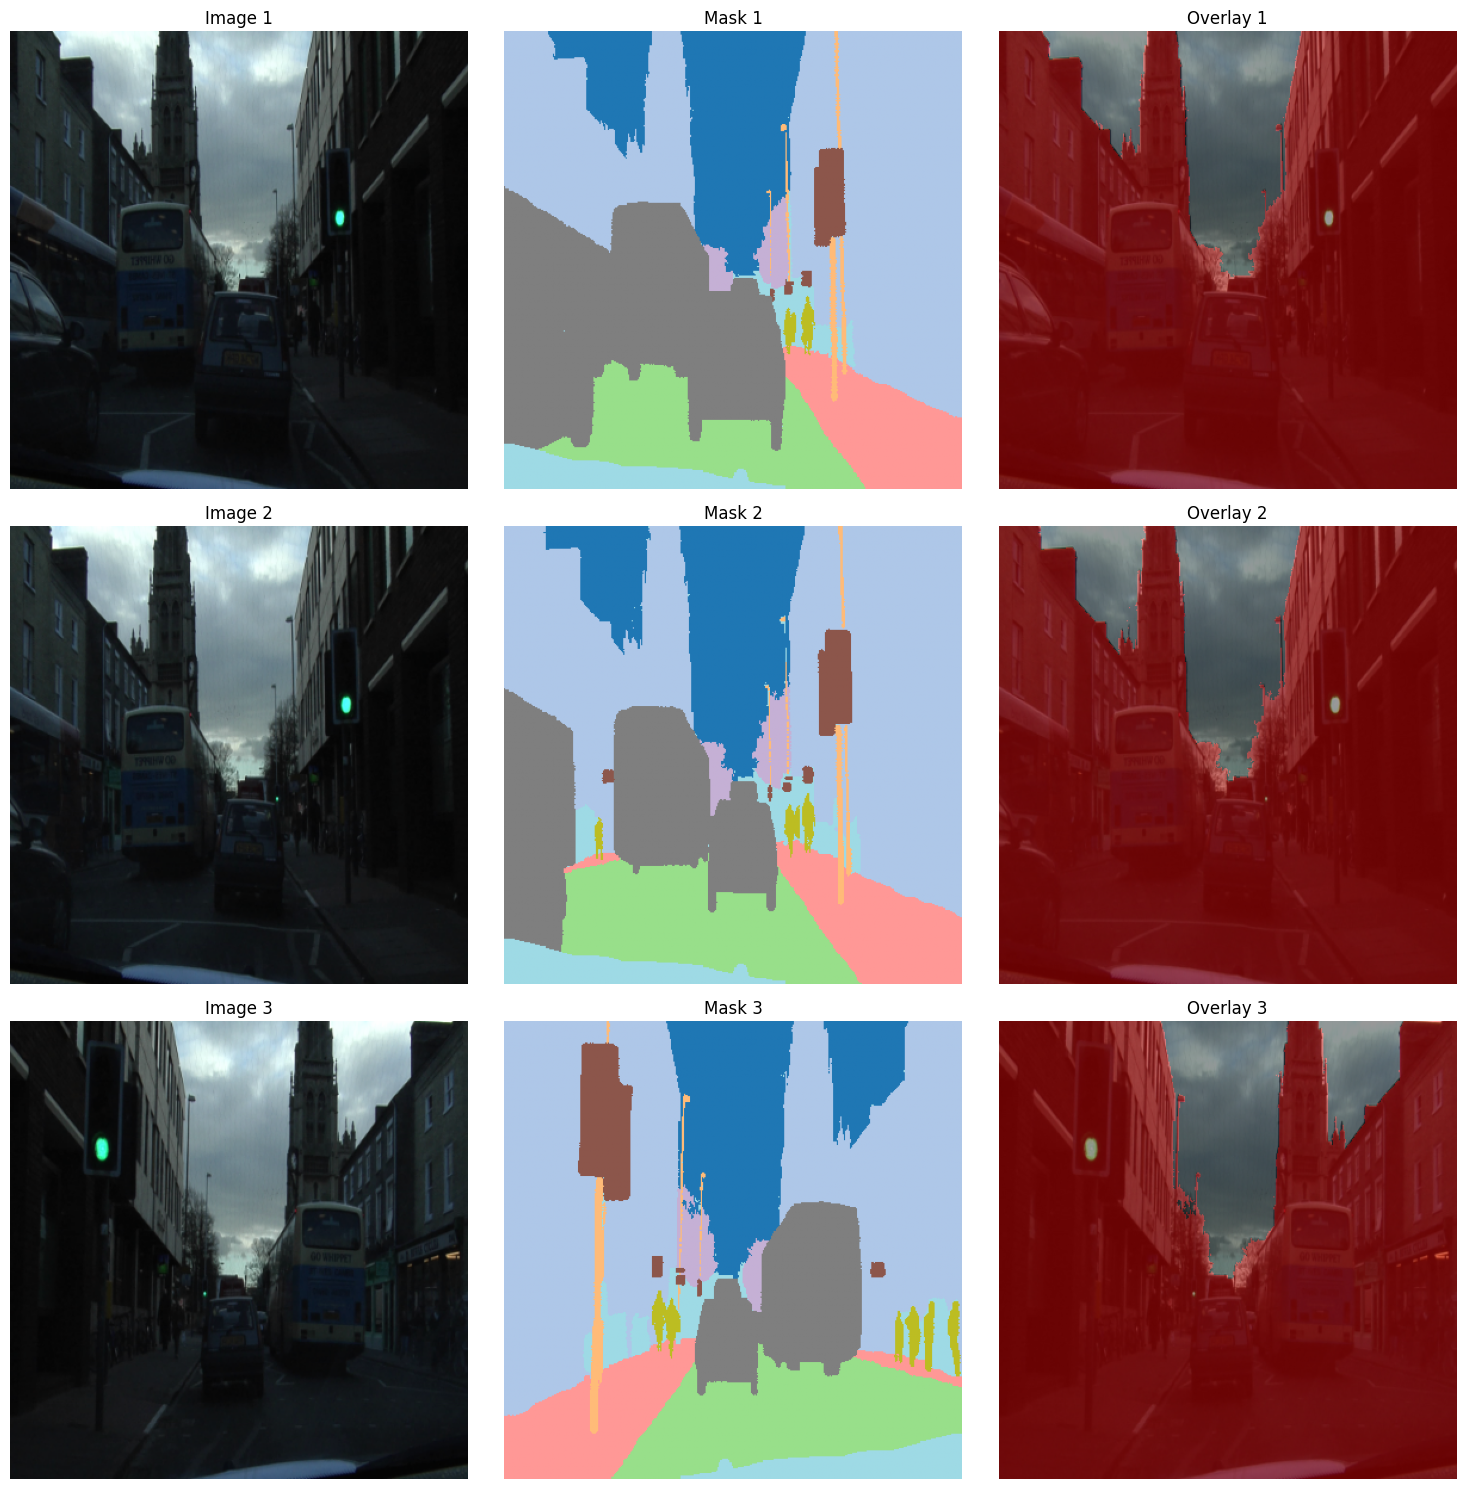

Image shape: torch.Size([3, 384, 384])
Mask shape: torch.Size([384, 384])
Mask unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11])


In [49]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    image, mask = train_dataset[i]

    img_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)

    mask_np = mask.numpy()

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')

    overlay = img_np.copy()
    mask_colored = np.zeros_like(img_np)
    mask_colored[mask_np > 0] = [1, 0, 0]
    overlay = overlay * 0.6 + mask_colored * 0.4

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")


## Инициализация модели

Создаём модель UNet и Lightning модуль для обучения.


In [50]:
unet_module = UNetModule(
    model=model,
    learning_rate=5e-4,
    weight_decay=1e-4,
    ignore_index=11,  # Void
)

sample_input = torch.randn(1, 3, img_size[0], img_size[1])
with torch.no_grad():
    sample_output = unet_module(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in unet_module.parameters()):,}")

Input shape: torch.Size([1, 3, 384, 384])
Output shape: torch.Size([1, 12, 384, 384])
Model parameters: 32,522,700


## Обучение модели

Настраиваем callbacks и запускаем обучение с использованием PyTorch Lightning.


In [51]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_miou',
    mode='max',
    save_top_k=1,
    filename='unet-{epoch:02d}-{val_miou:.4f}',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_miou',
    mode='max',
    patience=12,
    verbose=True
)

logger = TensorBoardLogger('lightning_logs', name='unet_segmentation')

use_gpu = torch.cuda.is_available()
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if use_gpu else 'cpu',
    devices=1,
    precision='16-mixed' if use_gpu else 32,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10,
    val_check_interval=1.0,
    gradient_clip_val=1.0,
    accumulate_grad_batches=2 if (use_gpu and batch_size < 8) else 1
)

trainer.fit(unet_module, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ Unet             │ 32.5 M │ train │     0 │
│ 1 │ ce    │ CrossEntropyLoss │      0 │ train │     0 │
│ 2 │ dice  │ DiceLoss         │      0 │ train │     0 │
└───┴───────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 32.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 225                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved. New best score: 0.212
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved by 0.109 >= min_delta = 0.0. New best score: 0.322
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved by 0.088 >= min_delta = 0.0. New best score: 0.409
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved by 0.010 >= min_delta = 0.0. New best score: 0.419
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved by 0.020 >= min_delta = 0.0. New best score: 0.439
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved by 0.062 >= min_delta = 0.0. New best score: 0.501
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved by 0.005 >= min_delta = 0.0. New best score: 0.505
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_miou improved by 0.073 >= min_delta = 0.0. New best score: 0.579
INFO:pytorch_lightning.callbacks.ear

## Оценка на тестовом датасете

Оцениваем качество модели на тестовом датасете.


In [52]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")


Best model path: lightning_logs/unet_segmentation/version_1/checkpoints/unet-epoch=37-val_miou=0.7095.ckpt


## Визуализация результатов

Визуализируем предсказания модели на нескольких примерах из валидационного датасета.


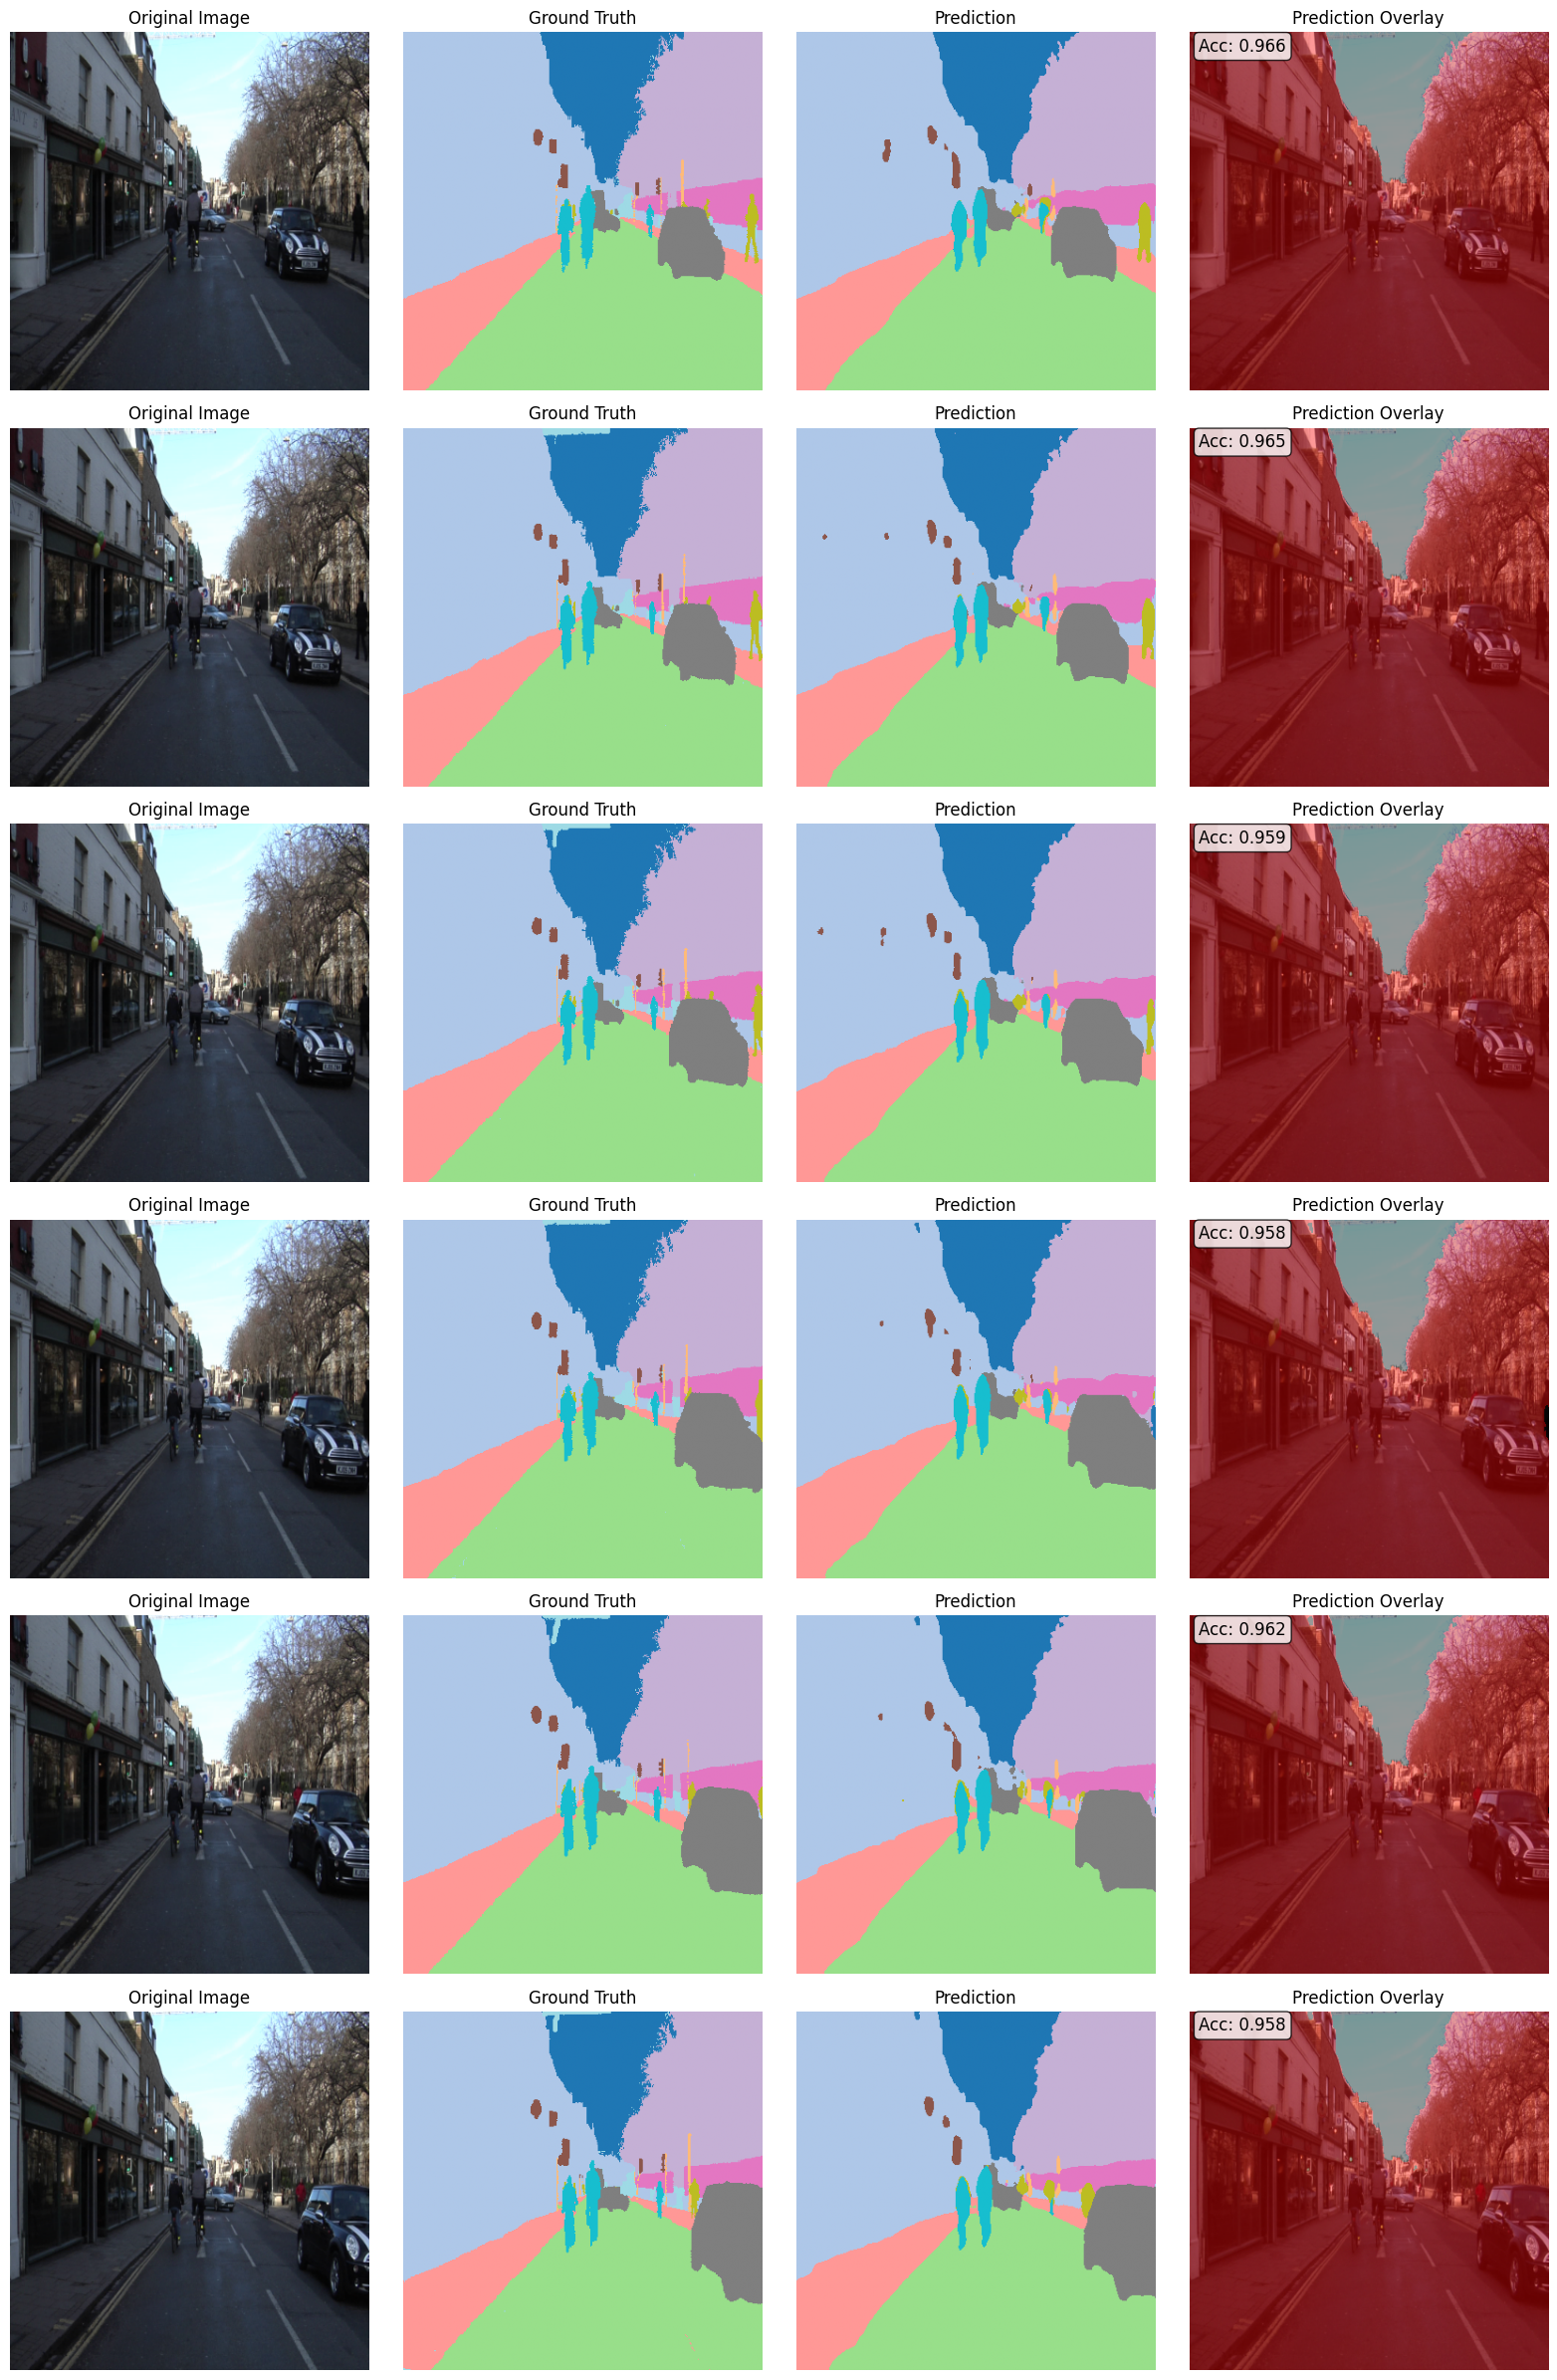

In [53]:
unet_module.eval()
device = next(unet_module.parameters()).device

num_samples = 6
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

with torch.no_grad():
    for idx in range(num_samples):
        image, mask = val_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)

        logits = unet_module(image_batch)
        pred = torch.argmax(logits, dim=1).cpu().squeeze()

        img_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)

        mask_np = mask.numpy()
        pred_np = pred.numpy()

        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 2].set_title('Prediction')
        axes[idx, 2].axis('off')

        overlay = img_np.copy()
        pred_colored = np.zeros_like(img_np)
        pred_colored[pred_np > 0] = [1, 0, 0]
        overlay = overlay * 0.6 + pred_colored * 0.4

        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Prediction Overlay')
        axes[idx, 3].axis('off')

        correct = (pred_np == mask_np).sum()
        total = mask_np.size
        pixel_acc = correct / total
        axes[idx, 3].text(10, 20, f'Acc: {pixel_acc:.3f}',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Метрики на валидационном датасете

Вычисляем детальные метрики на валидационном датасете.


In [54]:
def compute_metrics(preds, targets, n_classes=12, ignore_index=11):
    """Compute mIoU (excluding ignore_index) + pixel accuracy (excluding ignore_index)."""
    valid_mask = targets != ignore_index
    preds_valid = preds[valid_mask]
    targets_valid = targets[valid_mask]

    ious = []
    for cls in range(n_classes):
        if cls == ignore_index:
            continue
        pred_cls = (preds_valid == cls)
        target_cls = (targets_valid == cls)
        intersection = (pred_cls & target_cls).float().sum()
        union = (pred_cls | target_cls).float().sum()
        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.append(iou.item())

    mean_iou = float(np.mean(ious)) if len(ious) else 0.0
    pixel_acc = float((preds_valid == targets_valid).float().mean().item()) if preds_valid.numel() else 0.0

    return {'mean_iou': mean_iou, 'pixel_acc': pixel_acc, 'iou_per_class': ious}

unet_module.eval()
device = next(unet_module.parameters()).device

all_preds = []
all_targets = []

val_loader_eval = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

with torch.no_grad():
    for images, masks in tqdm(val_loader_eval, desc="Evaluating"):
        images = images.to(device)
        logits = unet_module(images)
        preds = torch.argmax(logits, dim=1).cpu()

        all_preds.append(preds)
        all_targets.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

metrics = compute_metrics(all_preds, all_targets, n_classes=12, ignore_index=11)

camvid_classes = [
    'Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign-Symbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Void'
]

print("="*60)
print("Validation Metrics (Void excluded):")
print("="*60)
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Pixel Accuracy: {metrics['pixel_acc']:.4f}")
print("\nIoU per class:")
cls_names = [c for i, c in enumerate(camvid_classes) if i != 11]
for cls_name, iou in zip(cls_names, metrics['iou_per_class']):
    print(f"  {cls_name}: {iou:.4f}")
print("="*60)

Evaluating: 100%|██████████| 13/13 [01:35<00:00,  7.37s/it]


Validation Metrics (Void excluded):
Mean IoU: 0.7517
Pixel Accuracy: 0.9508

IoU per class:
  Sky: 0.9395
  Building: 0.9093
  Column-Pole: 0.1249
  Road: 0.9706
  Sidewalk: 0.8828
  Tree: 0.9134
  Sign-Symbol: 0.5736
  Fence: 0.7442
  Car: 0.8706
  Pedestrian: 0.5465
  Bicyclist: 0.7931
